# Theano, Lasagne
и с чем их едят

# разминка
* напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
* массив чисел от 0 до N - numpy.arange(N)

In [1]:
!pip install Theano==0.8.2
!pip install https://github.com/Lasagne/Lasagne/archive/master.zip

    100% |████████████████████████████████| 225kB 409kB/s 


In [2]:
import numpy as np
def sum_squares(N):
    return np.sum(np.arange(N) ** 2)

In [3]:
%%time
sum_squares(10**8)

CPU times: user 296 ms, sys: 452 ms, total: 748 ms
Wall time: 328 ms


662921401752298880

# theano teaser

Как сделать то же самое

In [4]:
import theano
import theano.tensor as T

Using gpu device 0: Quadro M1000M (CNMeM is disabled, cuDNN 5105)
/home/ivan/.virtualenvs/math/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [5]:


#будущий параметр функции
N = T.scalar("a dimension",dtype='int32')


#рецепт получения суммы квадратов
result = (T.arange(N)**2).sum()

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs = [N],outputs=result)

In [6]:
%%time
sum_function(10**8)

CPU times: user 192 ms, sys: 44 ms, total: 236 ms
Wall time: 234 ms


array(662921401752298880)

# Как оно работает?
* Нужно написать "рецепт" получения выходов по входам
* То же самое на заумном: нужно описать символический граф вычислений


* 2 вида зверей - "входы" и "преобразования"
* Оба могут быть числами, массивами, матрицами, тензорами и т.п.


* Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.
 * N - вход в примере выше


* Преобразования - рецепты вычисления чего-то на основе входов и констант
 * (T.arange(N)^2).sum() - 3 последовательных преобразования N
 * Работают почти 1 в 1 как векторные операции в numpy
 * почти всё, что есть в numpy есть в theano tensor и называется так же
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * и так далее...
   * Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла
 
 
Ничего не понятно? Сейчас исправим.

In [7]:
#входы
example_input_integer = T.scalar("вход - одно число(пример)",dtype='float32')

example_input_tensor = T.tensor4("вход - четырёхмерный тензор(пример)")
#не бойся, тензор нам не пригодитс


input_vector = T.vector("вход - вектор целых чисел", dtype='int32')


In [8]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector


In [9]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [10]:
#теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector("v1", dtype='float32')
my_vector2 = T.vector("v2", dtype='float32')

In [11]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + T.constant(1))

In [12]:
print (my_transformation)
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


# Компиляция
* До этого момента, мы использовали "символические" переменные
 * писали рецепт вычислений, но ничего не вычисляли
* чтобы рецепт можно было использовать, его нужно скомпилировать

In [13]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [14]:
#можно вызвать вот-так:
print ("using python lists:")
print (my_function([1,2,3],[4,5,6]))
print()

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print ("using numpy arrays:")
print (my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float')))


using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]
()
using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# хинт для отладки
* Если ваша функция большая, компиляция может отнять какое-то время.
* Чтобы не ждать, можно посчитать выражение без компиляции
* Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее


In [15]:
#словарик значений для входов
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print my_transformation.eval(my_function_inputs)


#можно вычислять преобразования на ходу
print("сумма 2 векторов")
print((my_vector + my_vector2).eval(my_function_inputs))

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print("форма первого вектора")
print(my_vector.shape.eval({my_vector:[1,2,3]}))


[  2.1721766    5.23752832  15.77397728]
сумма 2 векторов
[ 5.  7.  9.]
форма первого вектора
[3]


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
* Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам: MSE (2 pts)

In [16]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно

v1 = T.vector("v1", dtype='float32')
v2 = T.vector("v2", dtype='float32')

mse = T.sum((v2- v1) ** 2) / v1.shape

compute_mse = theano.function([v1, v2], mse, allow_input_downcast=True)

In [17]:
#тесты
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print ('Wrong result:')
                print ('mse(%s,%s)'%(el,el_2))
                print ("should be: %f, but your function returned %f"%(true_mse,my_mse))
                raise ValueError("Что-то не так")

print ("All tests passed")
            
    

All tests passed


# Shared variables

* Входы и преобразования - части рецепта. 
 * Они существуют только во время вызова функции.


* Shared переменные - всегда остаются в памяти
 * им можно поменять значение 
   * (но не внутри символического графа. Об этом позже)
 * их можно включить в граф вычислений
 
 
* хинт - в таких переменных удобно хранить параметры и гиперпараметры
 * например, веса нейронки или learning rate, если вы его меняете

In [18]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10,dtype='float64'))

In [19]:

#получить (численное) значение переменной
print ("initial value",shared_vector_1.get_value())

('initial value', array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))


In [20]:
#задать новое значение
shared_vector_1.set_value( np.arange(5) )

#проверим значение
print ("new value", shared_vector_1.get_value())

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

('new value', array([ 0.,  1.,  2.,  3.,  4.]))


# Теперь сам

In [21]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = input_scalar * shared_vector_1


shared_times_n = theano.function([input_scalar], scalar_times_shared, allow_input_downcast=True)


In [22]:
print ("shared:", shared_vector_1.get_value())

print ("shared_times_n(5)",shared_times_n(5))

print ("shared_times_n(-0.5)",shared_times_n(-0.5))


('shared:', array([ 0.,  1.,  2.,  3.,  4.]))
('shared_times_n(5)', array([  0.,   5.,  10.,  15.,  20.]))
('shared_times_n(-0.5)', array([-0. , -0.5, -1. , -1.5, -2. ]))


In [23]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1,0,1])
print ("shared:", shared_vector_1.get_value())

print ("shared_times_n(5)",shared_times_n(5))

print ("shared_times_n(-0.5)",shared_times_n(-0.5))


('shared:', array([-1.,  0.,  1.]))
('shared_times_n(5)', array([-5.,  0.,  5.]))
('shared_times_n(-0.5)', array([ 0.5, -0. , -0.5]))


# T.grad, самое вкусное
* theano умеет само считать производные. Все, которые существуют.
* Производные считаются в символическом, а не численном виде

Ограничения
* За раз можно считать производную __скалярной__ функции по одной или нескольким скалярным или векторным аргументам
* Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [24]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

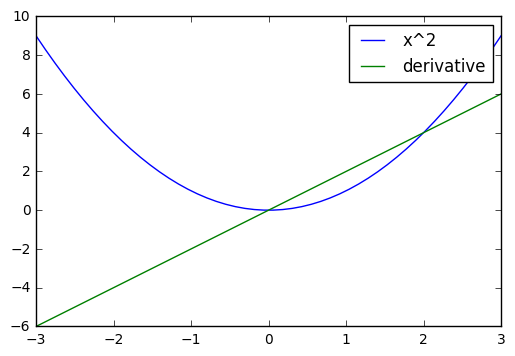

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3,3)
x_squared = list(map(fun,x))
x_squared_der = list(map(grad,x))

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# теперь сам

In [26]:

my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar,der_by_vector =  T.grad(weird_psychotic_function, my_scalar),  T.grad(weird_psychotic_function, my_vector)


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)


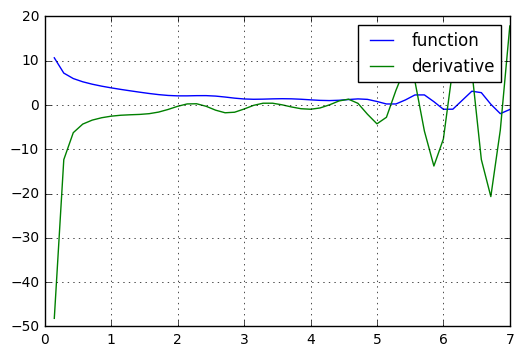

In [27]:
#график функции и твоей производной
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


# Последний штрих - Updates

* updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции

* фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции

Например,

In [28]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1:scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [29]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print ("initial shared value:" ,shared_vector_1.get_value())

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print ("compute_and_save(2) returns",compute_and_save(2))

#проверим, что в shared_vector_1
print ("new shared value:" ,shared_vector_1.get_value())



('initial shared value:', array([ 0.,  1.,  2.,  3.,  4.]))
('compute_and_save(2) returns', [array([ 0.,  2.,  4.,  6.,  8.])])
('new shared value:', array([ 0.,  2.,  4.,  6.,  8.]))


# Логистическая регрессия
Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [30]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target


print ("y [форма - %s]:"%(str(y.shape)),y[:10])

print ("X [форма - %s]:"%(str(X.shape)))
print (X[:3])

('y [\xd1\x84\xd0\xbe\xd1\x80\xd0\xbc\xd0\xb0 - (360,)]:', array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1]))
X [форма - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
 

In [31]:
# переменные и входыi
shared_weights = theano.shared(np.zeros(X.shape[1], dtype='float64'))

input_X = T.matrix("x", dtype='float64')
input_y = T.vector("y", dtype='float64')

In [32]:
predicted_y = T.dot(input_X, shared_weights)
loss = T.mean(T.log(1 + T.exp(-input_y * T.dot(input_X, shared_weights))))

grad = T.grad(loss, shared_weights)

updates = {
    shared_weights: shared_weights - grad
}

In [33]:
train_function = theano.function([input_X, input_y], loss, updates=updates, allow_input_downcast=True)
predict_function = theano.function([input_X], predicted_y, allow_input_downcast=True)

In [34]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

/home/ivan/.virtualenvs/math/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loss at iter 0:0.6931
('train auc:', 0.92887327808572528)
('test auc:', 0.94024691358024692)
loss at iter 1:0.3414
('train auc:', 0.92887327808572528)
('test auc:', 0.94024691358024692)
loss at iter 2:0.3414
('train auc:', 0.92887327808572528)
('test auc:', 0.94024691358024692)
loss at iter 3:0.3414
('train auc:', 0.92887327808572528)
('test auc:', 0.94024691358024692)
loss at iter 4:0.3414
('train auc:', 0.92887327808572528)
('test auc:', 0.94024691358024692)
resulting weights:


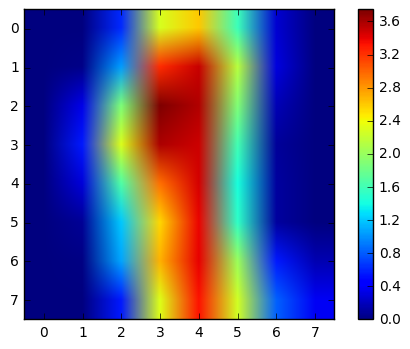

In [35]:
from sklearn.metrics import roc_auc_score, precision_score

for i in range(5):
    loss_i = train_function(X_train,y_train)
    
    print ("loss at iter %i:%.4f"%(i,loss_i))
    print ("train auc:",roc_auc_score(y_train,predict_function(X_train)))
    print ("test auc:",roc_auc_score(y_test,predict_function(X_test)))
    
print ("resulting weights:")
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

# lasagne
* lasagne - это библиотека для написания нейронок произвольной формы на theano
* библиотека низкоуровневая, границы между theano и lasagne практически нет

В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи
* картинки 28x28
* 10 цифр

In [36]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

((50000, 1, 28, 28), (50000,))


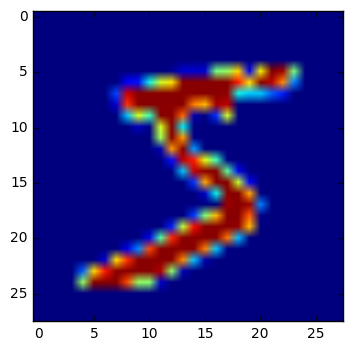

In [37]:
plt.imshow(X_train[0,0])

In [38]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [39]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

#полносвязный слой, который принимает на вход input layer и имеет 100 нейронов.
# нелинейная функция - сигмоида как в логистической регрессии
# слоям тоже можно давать имена, но это необязательно
dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=50,
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   name = "hidden_dense_layer")

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')


In [40]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [41]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print (all_weights)

[hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [42]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [43]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить
* данных теперь много, поэтому лучше учиться стохастическим градиентным спуском
* для этого напишем функцию, которая бьёт выпорку на мини-батчи (в обычном питоне, не в theano)

In [44]:
# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# X - тензор из картинок размером (много, 1, 28, 28), например - X_train
# y - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
#batch_size - одно число - желаемый размер группы

#что нужно сделать
# 1) перемешать данные
# - важно перемешать X и y одним и тем же образом, чтобы сохранить соответствие картинки ответу на неё
# 3) побить данные на подгруппы так, чтобы в каждой подгруппе было batch_size картинок и ответов
# - если число картинок не делится на batch_size, одну подгруппу можно вернуть другого размера
# 4) вернуть список (или итератор) пар:
# - (подгруппа картинок, ответы из y на эту подгруппу)

def iterate_minibatches(inputs, targets, batchsize):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

#
#
#
#
#
#
#
# Всё плохо и ты не понимаешь, что от тебя хотят?
# можешь поискать похожую функцию в примере
# https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

# Процесс обучения

In [45]:
import time

num_epochs = 100 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 1.394s
  training loss (in-iteration):		0.286911
  train accuracy:		91.54 %
  validation accuracy:		95.33 %
Epoch 2 of 100 took 1.402s
  training loss (in-iteration):		0.144562
  train accuracy:		95.64 %
  validation accuracy:		96.08 %
Epoch 3 of 100 took 1.423s
  training loss (in-iteration):		0.113106
  train accuracy:		96.57 %
  validation accuracy:		96.42 %
Epoch 4 of 100 took 1.365s
  training loss (in-iteration):		0.094565
  train accuracy:		97.16 %
  validation accuracy:		96.36 %
Epoch 5 of 100 took 1.498s
  training loss (in-iteration):		0.082506
  train accuracy:		97.47 %
  validation accuracy:		96.41 %
Epoch 6 of 100 took 1.495s
  training loss (in-iteration):		0.071518
  train accuracy:		97.82 %
  validation accuracy:		96.75 %
Epoch 7 of 100 took 1.366s
  training loss (in-iteration):		0.064846
  train accuracy:		97.94 %
  validation accuracy:		96.76 %
Epoch 8 of 100 took 1.560s
  training loss (in-iteration):		0.057577
  train accuracy:		98.22 %
  valida

In [46]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: колдун 80 уровня")
else:
    print ("Нужно больше магии!")

Final results:
  test accuracy:		96.85 %
Нужно больше магии!


# Нейронка твоей мечты


* Задача - сделать нейронку, которая получит точность 99% на валидации (validation accuracy)
 * __+1 балл__ за каждые 0.2% сверх 99%
 * Вариант "is fine too" - 97.5%. 
 * Чем выше, тем лучше.
 
__ В конце есть мини-отчётик, который имеет смысл прочитать вначале и заполнять по ходу работы. __
 

## Что можно улучшить:



 * размер сети
   * бОльше нейронов, 
   * бОльше слоёв, 
   * почти наверняка нужны свёртки
   * Пх'нглуи мглв'нафх Ктулху Р'льех вгах'нагл фхтагн! 
   
   
   
 * регуляризация - чтобы не переобучалось
   * приплюсовать к функции ошибки какую-нибудь сумму квадратов весов
   * можно сделать вручную, а можно - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   
   
   
 * Метод оптимизации - rmsprop, nesterov_momentum, adadelta, adagrad и т.п.
   * сходятся быстрее и иногда - к лучшему оптимуму
   * имеет смысл поиграть с размером батча, количеством эпох и скоростью обучения
   
   
   
 * Dropout - для борьбы с переобучением
   * `lasagne.layers.DropoutLayer(предыдущий_слой, p=вероятность_занулить)`
   
   
   
 * Свёрточные слои 
   * `network = lasagne.layers.Conv2DLayer(предыдущий_слой,`
    `                       num_filters = число нейронов,`
    `                        filter_size = (ширина_квадрата, высота_квадрата),`
    `                        nonlinearity = нелинейная_функция)`
   * ВАРНУНГ! могут учиться долго на CPU
     * Однако мы всё равно рекоммендуем обучить хотя бы маленькую свёртку
 
 * Любые другие слои и архитектуры
   * http://lasagne.readthedocs.org/en/latest/modules/layers.html
   * Pooling, Batch Normalization, etc
   
   
 * Наконец, можно поиграть с нелинейностями в скрытых слоях
   * tanh, relu, leaky relu, etc
 
 
   
Для удобства, ниже есть заготовка решения, которое можно заполнять, а можно выкинуть и написать своё

In [55]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

((50000, 1, 28, 28), (50000,))


In [56]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

In [57]:
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

conv_1 = lasagne.layers.Conv2DLayer(input_layer, num_filters=15, filter_size=5)

dens_1 = lasagne.layers.DenseLayer(conv_1, num_units=150,
                                   nonlinearity = lasagne.nonlinearities.leaky_rectify)

do_1 = lasagne.layers.DropoutLayer(dens_1,  p=0.5)

dense_output = lasagne.layers.DenseLayer(do_1, num_units=10,
                                         nonlinearity = lasagne.nonlinearities.softmax)

In [58]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [59]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print (all_weights)

[W, b, W, b, W, b]


In [60]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#<возможно добавить регуляризатор>

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adadelta(loss, all_weights,learning_rate=0.05)

In [61]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [62]:
#итерации обучения
import time

num_epochs = 200 #количество проходов по данным

batch_size = 200 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 200 took 3.089s
  training loss (in-iteration):		0.764301
  train accuracy:		78.38 %
  validation accuracy:		89.42 %
Epoch 2 of 200 took 3.261s
  training loss (in-iteration):		0.351766
  train accuracy:		89.71 %
  validation accuracy:		91.59 %
Epoch 3 of 200 took 3.467s
  training loss (in-iteration):		0.280893
  train accuracy:		91.80 %
  validation accuracy:		93.29 %
Epoch 4 of 200 took 2.978s
  training loss (in-iteration):		0.241197
  train accuracy:		93.01 %
  validation accuracy:		93.66 %
Epoch 5 of 200 took 3.108s
  training loss (in-iteration):		0.211252
  train accuracy:		93.85 %
  validation accuracy:		94.70 %
Epoch 6 of 200 took 3.090s
  training loss (in-iteration):		0.194328
  train accuracy:		94.35 %
  validation accuracy:		94.96 %
Epoch 7 of 200 took 3.254s
  training loss (in-iteration):		0.176543
  train accuracy:		94.93 %
  validation accuracy:		95.64 %
Epoch 8 of 200 took 3.449s
  training loss (in-iteration):		0.163694
  train accuracy:		95.25 %
  valida

KeyboardInterrupt: 

In [64]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Final results:
  test accuracy:		98.38 %


Отчётик, примерный его вид.

Творческий подход приветствуется, но хотелось бы узнать про следующие вещи:
* идея
* краткая история правок
* как выглядит сеть и почему
* каким методом обучается и почему
* регуляризована ли и как

Строгих математических выводов от вас никто не ждёт, вариант 
 * "Попробовал так, получилось лучше, чем вот-так, а тот третий вариант по названию не понравился" - не предел мечты, но __ок__
 * "Почитал такие статьи, сделал такие эксперименты, пришёл к такому выводу" - __идеально_
 * "сделал так, потому что в вон-той демке другой чувак так сделал, но тебе об этом не скажу, а придумаю какую-нибудь наукообразную чушь" - __не ок__

### Привет, я `@menshikh-iv`, и вот моя история

Когда-то давно, когда трава была зеленее, а до дедлайна ещё оставалось больше часа, мне в голову пришла идея:

Нужно посмотреть, как чОткие пацаны делают state of the art на MNIST (http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html - хорошая подборка релевантных статей).
Стало грустно, так как времени совсем мало, поэтому ....

##### А давай, я сделаю нейронку, которая
будет содержать в себе пару мешков волшебной пыли и возьмёт эти несчастные 99% accuracy. Учить как обычно (не хочется заморачиваться с аугментацией и прочими техниками), т.к. до дедлайна слишком мало времени. Набросаем свёрток  и поглядим что выйдет.


Начал я значит с того, что прицепил входной слой к выходному софтмаксу (чтобы получить лулзов), это работало плоховато, но работало, я аж удивился от неожиданности.

Вначале я добавил один сверточный слой и прогнал 20 итераций. Было слишком медленно, хотя я сконфигурировал гпу заранее, полез разбираться. Оказалось, что theano просто перестала видеть карту, хотя в nvidia-smi всё в порядке (у них про это куча issue на гитхабе открытых, никто не может понять причину).

##### В один прекрасный день, когда ничего не предвещало беды,
В итоге, после 20 минут, я таки заставил его подхватить карточку, прогнал, получил 94.95% на валидации и был опечален: всё очень плохо.

Почесав репу, я решил добросить дропаут и увеличить батч до 200 (вообще тему с оверфитом нужно проверять, а не угадывать, но у нас же час до дедлайна, придётся ванговать). В итоге, получаем 97.54 (что соответствует варианту "is fine too", но чсв совершенно не удволетворяет).

Окей, меняем rmspror на adadelta, подкручиваем дропаут, доползли до 98.22%. Окей, неплохо идём. Теперь попробуем немного усилить сетку ещё одним полносвязным слоем и понаблюдать за ошибкой, достигли 98.36%, чёрт, дальше видимо будет сложнее

...

Прошло некоторое время с попытками усложнения сетки в виде макспулинга и прочих приблуд, но лучше что-то сделать не получилось (кажется, что там есть потенциал, но тренируется это всё слишком медленно в условиях ограниченного времени). Ещё чуток поколдовав, сделал что-то в районе 98.4% и дальше не шло.

Вот и подошло время дедлайна, достигнуть быстро 99% не вышло :(



##### И вот, спустя $\infty$ попыток, на свет появилась
Сonv2D(15, 5)
Dense(150, leaky_rectify)
Dropout(0.5)
Dense(10, softmax)


Которая, после стольких мук, часа полтора обучения дала-таки точность

* точность на обучении - 99.7%
* точность на валидации - 98.44%
* точность на тесте - 98.38%


[опциональное послесловие и пожелания автору задания сдохнуть в страшных муках]